Thermal Convection
======

This example solves 2D dimensionless isoviscous thermal convection with a Rayleigh number of $10^4$, see Blankenbach *et al.* 1989 for details.

**This example introduces:**
1. Setting up material parameters and functions.
2. Setting up and solving systems, Stokes and Advection Diffusion.
3. Time stepping loop.
4. Plotting with glucifer

**Keywords:** material parameters, Stokes system, advective diffusive systems

**References**

B. Blankenbach, F. Busse, U. Christensen, L. Cserepes, D. Gunkel, U. Hansen, H. Harder, G. Jarvis, M. Koch, G. Marquart, D. Moore, P. Olson, H. Schmeling and T. Schnaubelt. A benchmark comparison for mantle convection codes. Geophysical Journal International, 98, 1, 23–38, 1989
http://onlinelibrary.wiley.com/doi/10.1111/j.1365-246X.1989.tb05511.x/abstract

In [309]:
import underworld as uw
from underworld import function as fn
import glucifer
import math

Setup parameters
-----

In [310]:
# Set number of dimensions.
dim = 2
# Set simulation box size.
boxHeight = 1.0
boxLength = 2.0
# Set the resolution.
res = 32
# Set min/max temperatures.
tempMin = 0.0
tempMax = 1.0

Create mesh and variables
------

The mesh object has both a primary and sub mesh. "Q1/dQ0" produces a primary mesh with element type Q1 and a sub-mesh with elements type dQ0. Q1 elements have node points at the element corners, dQ0 elements have a single node at the elements centre.

In [311]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (2*res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))

Create mesh variables.  Note the pressure field uses the sub-mesh. 

In [312]:
velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

# Initialise values
velocityField.data[:]       = [0.,0.]
pressureField.data[:]       = 0.
temperatureDotField.data[:] = 0.

Set up material parameters and functions
-----

Set functions for viscosity, density and buoyancy force. These functions and variables only need to be defined at the beginning of the simulation, not each timestep.

In [313]:
# Set viscosity to be a constant.
viscosity = 1.

# Rayleigh number.
Ra = 1.0e4

# Construct our density function.
densityFn = Ra * temperatureField

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

Create initial & boundary conditions
----------

Set a sinusoidal perturbation in the temperature field to seed the onset of convection.

In [314]:
pertStrength = 0.2
deltaTemp = tempMax - tempMin
for index, coord in enumerate(mesh.data):
    pertCoeff = math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    temperatureField.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
    temperatureField.data[index] = max(tempMin, min(tempMax, temperatureField.data[index]))



Set top and bottom wall temperature boundary values.

In [315]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin

Construct sets for ``I`` (vertical) and ``J`` (horizontal) walls. Note both sets contain the corners nodes of the domain.

In [316]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

Create Direchlet, or fixed value, boundary conditions. More information on setting boundary conditions is found in the **06_Systems.ipynb** user guide.

In [317]:
# 2D velocity vector can have two Dirichlet conditions on each vertex, 
# v_x is fixed on the iWalls (vertical), v_y is fixed on the jWalls (horizontal)
freeslipBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                               indexSetsPerDof = (iWalls, jWalls) )

# Temperature is held constant on the jWalls
tempBC     = uw.conditions.DirichletCondition( variable        = temperatureField, 
                                               indexSetsPerDof = (jWalls,) )

**Plot initial conditions for temperature**



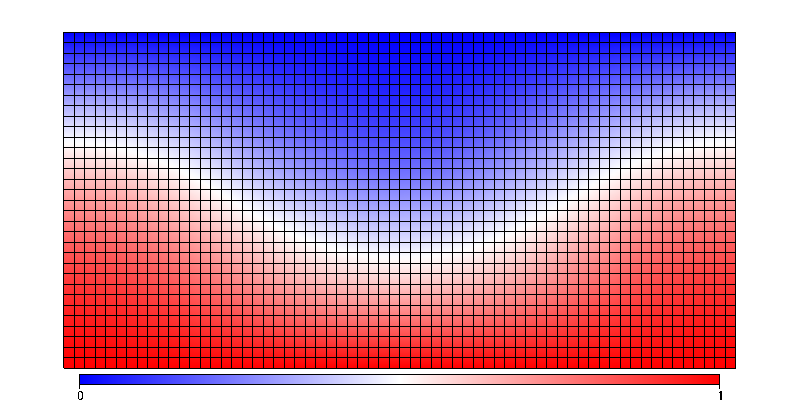

In [318]:
figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.Mesh(mesh) )
figtemp.show()

System setup
-----

**Setup a Stokes system**

Underworld uses the Stokes system to solve the [incompressible Stokes equations](https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations).  

In [319]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = [freeslipBC,],
                               fn_viscosity   = viscosity, 
                               fn_bodyforce   = buoyancyFn )

# get the default stokes equation solver
solver = uw.systems.Solver( stokesPIC )

**Set up the advective diffusive system**

Underworld uses the AdvectionDiffusion system to solve the temperature field given heat transport through the velocity field. More information on the advection diffusion equation can be found [here](https://en.wikipedia.org/wiki/Convection%E2%80%93diffusion_equation).

In [320]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField, 
                                         fn_diffusivity = 1.0, 
                                         conditions     = [tempBC,] )

Main time stepping loop
-----
Time and steps are initialised to zero. 

In [321]:
time = 0.
step = 0
steps_end = 2
while step < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff.integrate(dt)
    step += 1

**Plot final temperature and velocity field**


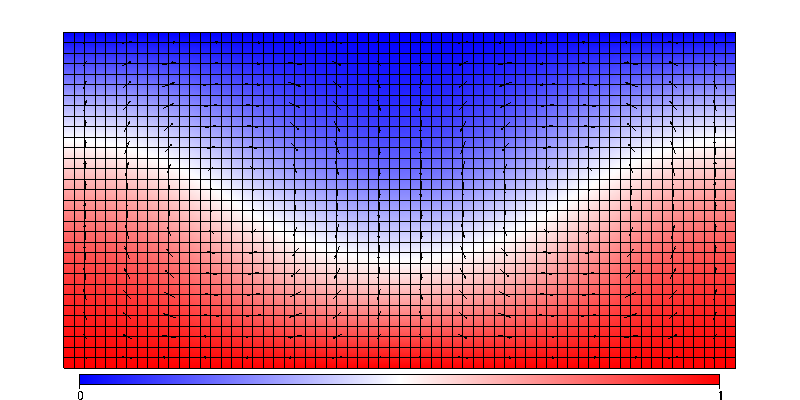

In [322]:
# plot figure
figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField/100.0, arrowHead=0.2, scaling=0.1) )
figtemp.append( glucifer.objects.Mesh(mesh))
figtemp.show()


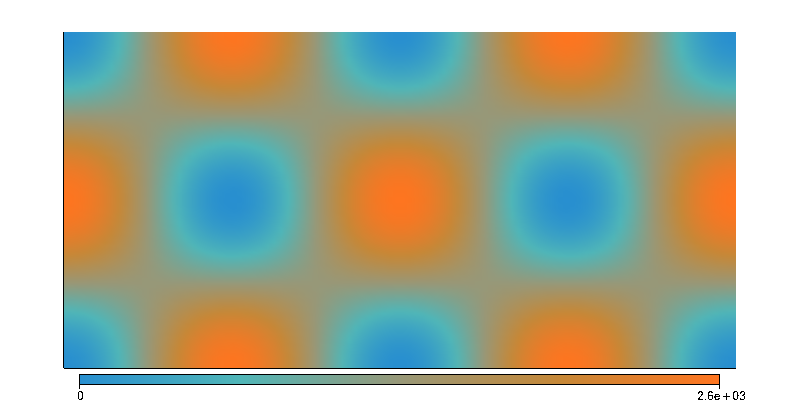

In [323]:
figVelocityMag = glucifer.Figure( figsize=(800,400) )
figVelocityMag.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField,velocityField)))
figVelocityMag.show()

## Mesh deformation

In [324]:
mesh.reset()

In [325]:
intensity = 20.

testfn = fn.math.dot(velocityField,velocityField)

testfn = testfn /((fn.math.dot(velocityField,velocityField).evaluate(mesh).max() - \
    fn.math.dot(velocityField,velocityField).evaluate(mesh).min()))*intensity

testfn += (1.- fn.math.dot(velocityField,velocityField).evaluate(mesh).min())
#testfn *= intensity

In [326]:
testfn.evaluate(mesh).min(), testfn.evaluate(mesh).max()

(1.0, 21.0)

In [327]:
meshField[1]

In [328]:
yField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
yField.data[:] = 0.

yBC = uw.conditions.DirichletCondition( variable=yField, indexSetsPerDof=(jWalls,) )

xField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
xField.data[:] = 0.

xBC = uw.conditions.DirichletCondition( variable=xField, indexSetsPerDof=(iWalls,) )

In [329]:
# set bottom wall temperature bc
for index in mesh.specialSets["MinJ_VertexSet"]:
    yField.data[index] = mesh.maxCoord[1]
# set top wall temperature bc
for index in mesh.specialSets["MaxJ_VertexSet"]:
    yField.data[index] = mesh.minCoord[1]
    
# set bottom wall temperature bc
for index in mesh.specialSets["MinI_VertexSet"]:
    xField.data[index] = mesh.minCoord[0]
## set top wall temperature bc
for index in mesh.specialSets["MaxI_VertexSet"]:
    xField.data[index] = mesh.maxCoord[0]

In [330]:
yLaplaceEquation = uw.systems.SteadyStateHeat(temperatureField=yField, fn_diffusivity=testfn, conditions=[yBC,])
xLaplaceEquation = uw.systems.SteadyStateHeat(temperatureField=xField, fn_diffusivity=testfn, conditions=[xBC,])

In [331]:
# get the default heat equation solver
yLaplaceSolver = uw.systems.Solver(yLaplaceEquation)
# solve
yLaplaceSolver.solve()


# get the default heat equation solver
xLaplaceSolver = uw.systems.Solver(xLaplaceEquation)
# solve
xLaplaceSolver.solve()

In [332]:
dcy = yField.evaluate(mesh.data)[::-1,0].copy()

dcx = xField.evaluate(mesh.data)[::-1,0].copy()

In [333]:
with mesh.deform_mesh():
    mesh.data[:,1] = dcy
    mesh.data[:,0] = dcx

In [334]:
#meshField.evaluate(mesh)

In [335]:
time = 0.
step = 0
steps_end = 4
while step < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff.integrate(dt)
    step += 1


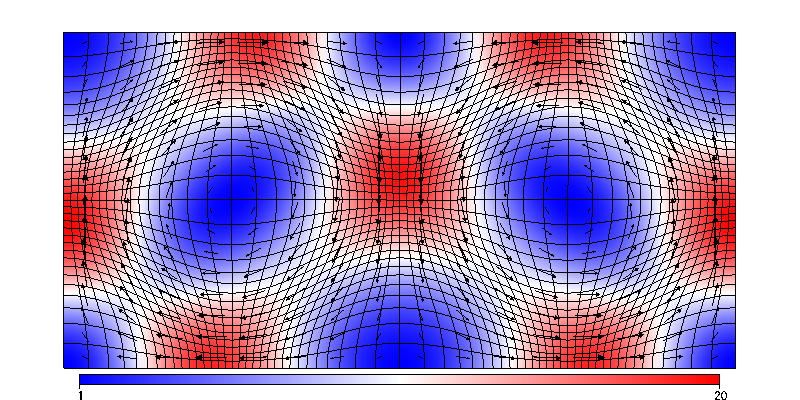

In [339]:
# plot figure
fig = glucifer.Figure( figsize=(800,400) )
fig.append( glucifer.objects.Surface(mesh, testfn, colours="blue white red") )
fig.append( glucifer.objects.VectorArrows(mesh, velocityField/100.0, arrowHead=0.2, scaling=0.2) )
fig.append( glucifer.objects.Mesh(mesh))
fig.show()